# Decode stimuli/block/licks from neural activity - DR single session

In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import sklearn as sk
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate

%matplotlib notebook

In [3]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
#     r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
#     r"Y:\DRpilot_644866_20230208\processed",
#     r"Y:\DRpilot_644866_20230209\processed",
#     r"Y:\DRpilot_644866_20230210\processed",
#     r"Y:\DRpilot_644867_20230220\processed",
#     r"Y:\DRpilot_644867_20230221\processed",
#     r"Y:\DRpilot_644867_20230222\processed",
#     r"Y:\DRpilot_644867_20230223\processed",
#     r"Y:\DRpilot_649943_20230213\processed", 
#     r"Y:\DRpilot_649943_20230214\processed",
#     r"Y:\DRpilot_649943_20230215\processed",
#     r"Y:\DRpilot_649943_20230216\processed",
]



## Load a single session

In [4]:
sel_session=0
session=Session(path=main_path[sel_session]) 
session.assign_unit_areas()
session=compute_smoothed_response_rate(session)

probeA areas found
probeB areas found
probeC areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1095: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials.loc[:,ss+'_smooth']=sg.convolve(stimTrials.loc[:,'trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1095: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials.loc[:,ss+'_smooth']=sg.convolve(stimTrials.loc[:,'trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\U

In [5]:
# trials table
session.trials

,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,vis_hit_trials,...,stimLatency,trial_stim_dur,avg_run_speed,vis1_interp,sound2_interp,sound1_interp,vis2_interp,catch_interp,cross_modal_dprime,intra_modal_dprime
0,0,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,18.201756,0.546012,NaN,NaN,NaN,NaN,NaN,NaN
1,674,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,19.262925,0.636215,NaN,NaN,NaN,NaN,NaN,NaN
2,1044,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,-0.154679,0.721164,NaN,NaN,NaN,NaN,NaN,NaN
3,1438,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,0.000000,0.798030,NaN,NaN,NaN,NaN,NaN,NaN
4,1841,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022345,0.5,0.000000,0.864853,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,213238,sound2,sound1,True,False,0.5,0.0,False,False,False,...,0.105667,0.5,23.424868,0.277474,NaN,0.606147,0.155597,NaN,0.859652,NaN
475,213592,vis2,sound1,False,False,0.0,0.5,False,True,False,...,0.022725,0.5,24.424886,0.273434,NaN,0.576080,NaN,NaN,0.794334,NaN
476,214441,sound1,sound1,True,True,0.5,0.0,False,False,False,...,0.091479,0.5,32.766758,0.269394,NaN,NaN,NaN,NaN,NaN,NaN
477,214823,vis1,sound1,False,False,0.0,0.5,True,False,False,...,0.022480,0.5,20.075889,0.265354,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# units table
session.good_units

,quality,cluster_id,probe,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,...,recovery_slope,amplitude,spread,velocity_above,velocity_below,area,AP_coord,DV_coord,ML_coord,area_short
id,,,,,,,,,,,,,,,,,,,,,
2208151110004,good,4,A,19.871350,0.99,0.049522,0.022552,37.552305,0.128942,3.578176,...,-0.036398,72.207525,90.0,0.732552,NaN,VPM,280.0,188.0,174.0,VPM
2208151110002,good,2,A,4.481252,0.99,0.053188,0.028146,9.644711,2.208028,2.251783,...,-0.078481,107.780595,90.0,1.854271,NaN,VPM,280.0,188.0,173.0,VPM
2208151110006,good,6,A,12.692753,0.99,0.025500,0.037872,28.045546,0.376475,3.028024,...,-0.088636,141.483615,90.0,0.309045,NaN,VPM,280.0,188.0,173.0,VPM
2208151110012,good,12,A,18.970627,0.99,0.050457,0.032922,35.733932,0.134704,3.578971,...,-0.076446,95.180865,100.0,1.299289,-0.343384,VPM,280.0,186.0,174.0,VPM
2208151110014,good,14,A,9.237390,0.99,0.061624,0.025082,64.905296,0.130465,4.600663,...,-0.077755,125.922615,50.0,-0.343384,-0.343384,VPM,280.0,186.0,174.0,VPM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208151160439,good,439,F,11.047175,0.99,0.035681,0.012408,32.232810,0.286242,2.405390,...,-0.101884,144.925365,50.0,-0.343384,-0.343384,MOs2/3,136.0,78.0,156.0,MOs
2208151160442,good,442,F,2.272084,0.99,0.334226,0.010561,49.006266,0.005357,2.917428,...,-0.035261,135.811065,40.0,1.373534,-1.030151,MOs2/3,136.0,75.0,156.0,MOs
2208151160443,good,443,F,36.168340,0.99,0.002827,0.001311,141.786831,0.001938,6.269814,...,-0.028106,166.776285,60.0,2.060302,0.068677,MOs2/3,136.0,75.0,156.0,MOs


In [7]:
session.good_units['area'].value_counts()

CP          83
LGd-co      52
CA1         47
PO          45
LP          32
VISpm5      32
VPM         30
LD          28
AUDpo5      27
AUDp6a      25
LGd-sh      23
TEa5        20
BST         18
TEa4        17
MOs6a       16
MOs2/3      15
PS          14
DG-sg       13
VISpm6a     12
MOs5        11
ZI          10
AUDp6b       8
DG-po        8
AUDpo6a      8
CA3          7
LPO          7
DG-mo        6
LGv          5
STR          5
IGL          5
VISpm4       4
RSPd6a       4
N/A          4
RSPd5        4
TH           2
VISli2/3     2
TEa2/3       2
IntG         1
VISpm6b      1
Name: area, dtype: int64

In [8]:
# spike times from one unit
session.spike_times[session.units.index[0]]

array([  11.01369951,   11.65646469,   11.81169766, ..., 4569.39638463,
       4569.65641736, 4571.51424639])

In [9]:
# information about each frame
session.frames

,vsyncTimes,frameDelay,runningSpeed
0,80.04110,0.020720,0.000000
1,80.05762,0.020720,19.208968
2,80.07423,0.022585,18.777305
3,80.09092,0.022585,18.777305
4,80.10810,0.022345,19.640630
...,...,...,...
216905,3698.19226,0.022550,5.611609
216906,3698.20886,0.022625,7.122426
216907,3698.22558,0.022625,7.985751
216908,3698.24227,0.022405,9.064906


In [10]:
# loop through sessions and make unit xarrays
time_before_flash = 0.25
trial_duration = 1.0
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### decode by area

In [11]:
# session.good_units['area'].value_counts()
# session.metadata
session.trials

,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,vis_hit_trials,...,stimLatency,trial_stim_dur,avg_run_speed,vis1_interp,sound2_interp,sound1_interp,vis2_interp,catch_interp,cross_modal_dprime,intra_modal_dprime
0,0,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,18.201756,0.546012,NaN,NaN,NaN,NaN,NaN,NaN
1,674,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,19.262925,0.636215,NaN,NaN,NaN,NaN,NaN,NaN
2,1044,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,-0.154679,0.721164,NaN,NaN,NaN,NaN,NaN,NaN
3,1438,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,0.000000,0.798030,NaN,NaN,NaN,NaN,NaN,NaN
4,1841,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022345,0.5,0.000000,0.864853,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,213238,sound2,sound1,True,False,0.5,0.0,False,False,False,...,0.105667,0.5,23.424868,0.277474,NaN,0.606147,0.155597,NaN,0.859652,NaN
475,213592,vis2,sound1,False,False,0.0,0.5,False,True,False,...,0.022725,0.5,24.424886,0.273434,NaN,0.576080,NaN,NaN,0.794334,NaN
476,214441,sound1,sound1,True,True,0.5,0.0,False,False,False,...,0.091479,0.5,32.766758,0.269394,NaN,NaN,NaN,NaN,NaN,NaN
477,214823,vis1,sound1,False,False,0.0,0.5,True,False,False,...,0.022480,0.5,20.075889,0.265354,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


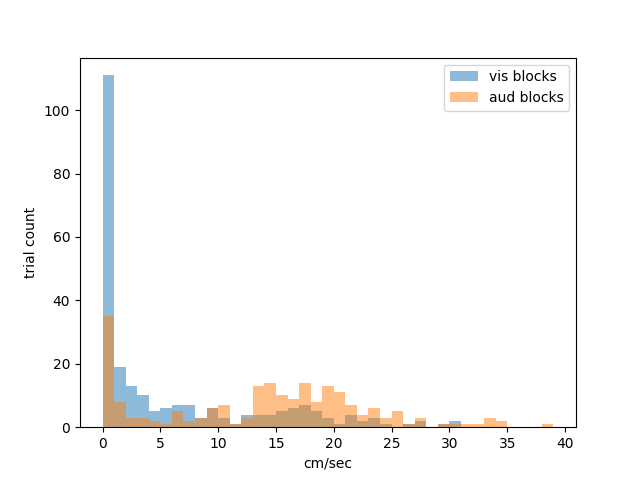

In [12]:
#running trial distribution across blocks
binsize=1
speed_bins=np.arange(0,np.ceil(session.trials['avg_run_speed'].max()),binsize)

fig,ax=plt.subplots()
ax.hist(session.trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins,alpha=0.5)
ax.hist(session.trials.query('trialstimRewarded=="sound1"')['avg_run_speed'],bins=speed_bins,alpha=0.5)

ax.set_ylabel('trial count')
ax.set_xlabel('cm/sec')
ax.legend(['vis blocks','aud blocks'])

In [40]:
#match running trial distribution

def match_run_speed(session):

    binsize=1
    speed_bins=np.arange(0,np.ceil(session.trials['avg_run_speed'].max()),binsize)

    visblock_run, edges = np.histogram(session.trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins)
    audblock_run, edges = np.histogram(session.trials.query('trialstimRewarded=="sound1"')['avg_run_speed'],bins=speed_bins)

    choose_trials=[]

    for ib,bb in enumerate(edges[:-1]):

        n_chosen_trials = np.min([visblock_run[ib],audblock_run[ib]])

        visblock_trials = session.trials.query('trialstimRewarded=="vis1" and \
                                                avg_run_speed>=@speed_bins[@ib] and \
                                                avg_run_speed<@speed_bins[@ib+1]').index

        audblock_trials = session.trials.query('trialstimRewarded=="sound1" and \
                                                avg_run_speed>=@speed_bins[@ib] and \
                                                avg_run_speed<@speed_bins[@ib+1]').index

        choose_trials.append(np.random.choice(visblock_trials,n_chosen_trials,replace=False))
        choose_trials.append(np.random.choice(audblock_trials,n_chosen_trials,replace=False))


    choose_trials = np.sort(np.hstack(choose_trials))
    
    return choose_trials

In [ ]:
choose_trials = match_run_speed(session)

run_matched_trials = session.trials.loc[choose_trials]

binsize=1
speed_bins=np.arange(0,np.ceil(session.trials['avg_run_speed'].max()),binsize)

fig,ax=plt.subplots(2,1,sharex=True,sharey=True)
ax[0].hist(run_matched_trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins,alpha=0.5)
ax[1].hist(run_matched_trials.query('trialstimRewarded=="sound1"')['avg_run_speed'],bins=speed_bins,alpha=0.5,color='tab:orange')

ax[0].set_ylabel('trial count')
ax[0].set_xlabel('cm/sec')
ax[1].set_ylabel('trial count')
ax[1].set_xlabel('cm/sec')
# ax.legend(['vis blocks','aud blocks'])


In [ ]:
run_matched_trials = session.trials.loc[choose_trials]

binsize=1
speed_bins=np.arange(0,np.ceil(session.trials['avg_run_speed'].max()),binsize)

fig,ax=plt.subplots()
ax.hist(session.trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins,alpha=0.5)
ax.hist(session.trials.query('trialstimRewarded=="sound1"')['avg_run_speed'],bins=speed_bins,alpha=0.5)
ax.hist(run_matched_trials.query('trialstimRewarded=="vis1"')['avg_run_speed'],bins=speed_bins,alpha=0.5,color='k')

ax.set_ylabel('trial count')
ax.set_xlabel('cm/sec')

ax.legend(['vis blocks','aud blocks','chosen trials'])

In [36]:
#shorten the area names to better lump together units
#get rig of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [37]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>20].index

Index(['CP', 'LGd', 'VISpm', 'CA1', 'PO', 'MOs', 'TEa', 'AUDpo', 'AUDp', 'LP',
       'VPM', 'LD', 'DG'],
      dtype='object')

In [ ]:
session.trials

In [41]:
trnum='all'
u_num='all'
u_min=20
n_repeats=1
binsize=0.2
time_bins=np.arange(-0.2,0.1,binsize)
balance_labels=1
balance_running=1
        
svc_results={}

svc_results[sel_session]={}

#exclude any trials that had opto stimulation
if 'trialOptoVoltage' in session.trials.columns:
    trial_sel = session.trials.query('trialOptoVoltage.isnull()').index
else:
    trial_sel = session.trials.index
#     trial_sel = run_matched_trials.index


# include_trials = ['all','target_response','non_target_non_response']

predict=['block_ids']#,'trial_response','stim_ids',]

# grab the stimulus ids
stim_ids = session.trials['trialStimID'][trial_sel].values
# or, use block IDs
block_ids = session.trials['trialstimRewarded'][trial_sel].values
#or, use whether mouse responded
trial_response = session.trials['trial_response'][trial_sel].values

svc_results[sel_session]['metadata']=session.metadata
svc_results[sel_session]['trial_numbers']=trnum
svc_results[sel_session]['unit_numbers']=u_num
svc_results[sel_session]['min_n_units']=u_min
svc_results[sel_session]['n_repeats']=n_repeats
svc_results[sel_session]['time_bins']=time_bins
svc_results[sel_session]['balance_labels']=balance_labels

# for p in predict:
# area_sel=['all']
p='block_ids'
svc_results[sel_session][p]={}


#choose what variable to predict
if p=='stim_ids':
    pred_var = stim_ids
elif p=='block_ids':
    pred_var = block_ids
elif p=='trial_response':
    pred_var = trial_response
        
area_sel = area_counts[area_counts>=u_min].index
# area_sel = ['VISpm','MOs']

for aa in area_sel:
    if aa=='all':
        unit_sel = session.good_units.index.values
    else:
        unit_sel = session.good_units.query('area_short==@aa').index.values
#         unit_sel = session.good_units.query('area_short.str.contains(@aa)').index.values
    svc_results[sel_session][p][aa]={}
    svc_results[sel_session][p][aa]['n_units']=len(unit_sel)
    
    for tt,t_start in enumerate(time_bins[:-1]):
        svc_results[sel_session][p][aa][tt]={}
        for nn in range(0,n_repeats):
            
            if balance_running:
                trial_sel = match_run_speed(session)
                #choose what variable to predict
            if p=='stim_ids':
                pred_var = session.trials['trialStimID'][trial_sel].values
            elif p=='block_ids':
                pred_var = session.trials['trialstimRewarded'][trial_sel].values
            elif p=='trial_response':
                pred_var = session.trials['trial_response'][trial_sel].values

            
            svc_results[sel_session][p][aa][tt][nn]={}
            
            if u_num=='all':
                unit_subset = np.random.choice(unit_sel,len(unit_sel),replace=False)
            else:
                unit_subset = np.random.choice(unit_sel,u_num,replace=False)

            if balance_labels:
                subset_ind=[]
                conds = np.unique(pred_var)
                cond_count=[]

                if trnum=='all':
                    for cc in conds:
                        cond_count.append(np.sum(pred_var==cc))
                    use_trnum=np.min(cond_count)
                else:
                    use_trnum = trnum

                for cc in conds:
                    cond_inds=np.where(pred_var==cc)[0]
                    if len(cond_inds)<use_trnum:
                        use_trnum=len(cond_inds)
                    subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
                subset_ind=np.sort(np.hstack(subset_ind))
            else:
                subset_ind=np.arange(0,len(trial_sel))
#                 trial_sel=trial_sel[subset_ind]
#                 pred_var=pred_var[subset_ind]

                
            sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                            trials=trial_sel[subset_ind],
                                            unit_id=unit_subset).mean(dim='time').values
            
            svc_results[sel_session][p][aa][tt][nn]=custom_decoder(
                input_data=sel_data.T,
                labels=pred_var[subset_ind].flatten())
            
#             svc_results[sel_session][p][aa][tt][nn]['shuffle']=custom_decoder(
#                 input_data=sel_data.T,
#                 labels=np.random.choice(pred_var,len(pred_var),replace=False).flatten())
            
            
            svc_results[sel_session][p][aa][tt][nn]['trial_sel_idx']=trial_sel

            
    print(aa+' done')

            
# savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results'

# with open(os.path.join(savepath,'decoder_results_100ms_incl_all_trials.pkl'), 'wb') as handle:
#     pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)        

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LGd done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VISpm done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CA1 done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


PO done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MOs done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TEa done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUDpo done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUDp done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VPM done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LD done
DG done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [52]:
svc_results[sel_session]['block_ids']['CA1'][0][nn]

{'cr':                sound1        vis1  accuracy   macro avg  weighted avg
 precision    0.559322    0.553030     0.556    0.556176      0.556176
 recall       0.528000    0.584000     0.556    0.556000      0.556000
 f1-score     0.543210    0.568093     0.556    0.555652      0.555652
 support    125.000000  125.000000     0.556  250.000000    250.000000,
 'pred_label': array(['sound1', 'vis1', 'vis1', 'sound1', 'vis1', 'vis1', 'sound1',
        'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1', 'sound1',
        'sound1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1',
        'vis1', 'sound1', 'sound1', 'vis1', 'vis1', 'vis1', 'sound1',
        'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1',
        'sound1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1', 'sound1',
        'vis1', 'vis1', 'sound1', 'sound1', 'vis1', 'sound1', 'sound1',
        'vis1', 'sound1', 'sound1', 'vis1', 'sound1', 'sound1', 'sound1',
        'sound1', 'sound1', 'sound1', 'sou

<IPython.core.display.Javascript object>


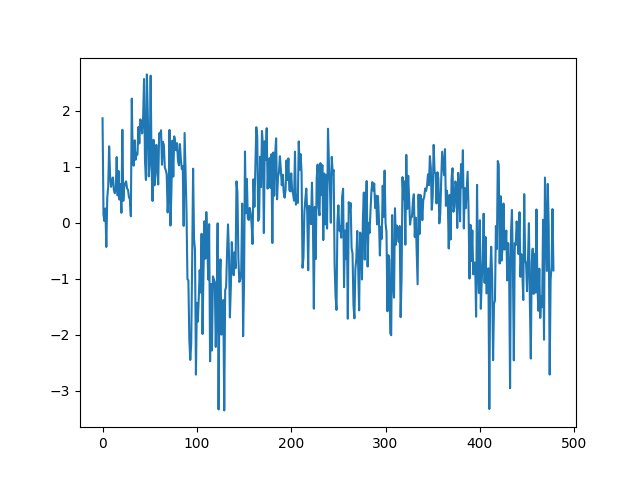

In [30]:
fig,ax=plt.subplots(1,1)
ax.plot(svc_results[sel_session][p]['MOs'][tt][nn]['decision_function'])

In [28]:
def custom_decoder(input_data,labels):
    
    output={}
    
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    
    scaler.fit(sel_data.T)
    X = scaler.transform(input_data)
    y = labels
    
    if len(np.unique(labels))>2:
        y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
    else:
        y_dec_func=np.full(len(y), fill_value=np.nan)
 
    if type(y[0])==bool:
        ypred=np.full(len(y), fill_value=False)
    elif type(y[0])==str:
        ypred=np.full(len(y), fill_value='       ')
    else:
        ypred=np.full(len(y), fill_value=np.nan)

    tidx_used=[]

    for train,test in skf.split(X, y):
        clf=svm.LinearSVC()
        clf.fit(X[train],y[train])
        ypred[test] = clf.predict(X[test])
        y_dec_func[test] = clf.decision_function(X[test])
        tidx_used.append([test])

    cr_dict=classification_report(y, ypred, output_dict=True)
    cr_df=pd.DataFrame.from_dict(cr_dict)

    output['cr']=cr_df
    output['pred_label']=ypred
    output['true_label']=y
    output['trial_sel_idx']=trial_sel
    output['trials_used']=tidx_used
    output['decision_function']=y_dec_func
    
    return output


def reformat_decoder_results(area_sel,svc_results,timepoints,n_repeats):
    # make into more plottable format
    plot_results={}
    timepoints=time_bins[1:]
    areas=area_sel

    for aa in areas:
        plot_results[aa]={}
        plot_results[aa]['vis1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['vis1'][:]=np.nan
        plot_results[aa]['vis2']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['vis2'][:]=np.nan
        
        plot_results[aa]['aud1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['aud1'][:]=np.nan
        plot_results[aa]['aud2']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['aud2'][:]=np.nan
        
        plot_results[aa]['True']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['True'][:]=np.nan
        plot_results[aa]['False']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['False'][:]=np.nan


    for aa in areas: #svc_results[ss]['results'].keys():
        if aa in svc_results.keys():
            for tt,tp in enumerate(timepoints):

                for nn in range(0,n_repeats):
                    if 'vis1' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['vis1'][['precision','recall']].values)
                        plot_results[aa]['vis1'][tt,nn]=vis1_perf
                        
                    if 'vis2' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['vis2'][['precision','recall']].values)
                        plot_results[aa]['vis2'][tt,nn]=vis1_perf

                    if 'sound1' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['sound1'][['precision','recall']].values)
                        plot_results[aa]['aud1'][tt,nn]=aud1_perf
                        
                    if 'sound2' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['sound2'][['precision','recall']].values)
                        plot_results[aa]['aud2'][tt,nn]=aud1_perf
                        
                    if 'True' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['True'][['precision','recall']].values)
                        plot_results[aa]['True'][tt,nn]=vis1_perf

                    if 'False' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['False'][['precision','recall']].values)
                        plot_results[aa]['False'][tt,nn]=aud1_perf
                        
    return plot_results

In [ ]:
### troubleshoot decision function



In [ ]:
pred_var

In [ ]:
pred_var_int=np.zeros(len(pred_var)).astype(int)
unique_vals=np.unique(pred_var)
for iu,uu in enumerate(unique_vals):
    pred_var_int[pred_var==uu]=iu
    
pred_var_recon=np.full(len(pred_var),fill_value='       ')
for iu,uu in enumerate(unique_vals):
    pred_var_recon[pred_var_int==iu]=uu
    
pred_var_recon==pred_var

In [ ]:
skf = StratifiedKFold(n_splits=5)
for train,test in skf.split(X, y):
    print('ntrain:',len(train),' ntest:',len(test))

In [ ]:
np.mean(y[train]=='sound1')

In [ ]:
svc_results[0]

In [ ]:
# session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
#                                         trials=trial_sel,
#                                         unit_id=unit_subset).mean(dim='time').values
# np.mean(ypred == 'sound1')

In [ ]:
svc_results[sel_session]['block_ids']['MOs'][0][0]['shuffle']
# svc_results[0]['stim_ids']
# svc_results[0]['trial_response']

In [ ]:
# predict_perf=np.zeros((len(session.trials),n_repeats))
# predict_perf[:]=np.nan
# for nn in range(0,n_repeats):
#     tridx=np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used'][np.sort(np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used']))]
#     predict_perf[tridx,nn]=(svc_results[sel_session]['block_ids']['MOs'][0][nn]['pred_label']==svc_results[sel_session]['block_ids']['MOs'][0][nn]['true_label'])

In [ ]:
# np.nanmean(predict_perf,1)

In [ ]:
plot_area='MOs'

predict_perf=np.zeros((len(trial_sel),n_repeats))
for nn in range(0,n_repeats):
    predict_perf[:,nn]=(svc_results[sel_session]['block_ids'][plot_area][0][nn]['pred_label']==
                       svc_results[sel_session]['block_ids'][plot_area][0][nn]['true_label'])

# predict_perf=np.zeros((len(session.trials),n_repeats))
# predict_perf[:]=np.nan
# for nn in range(0,n_repeats):
#     tridx=np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used'][
#         np.sort(np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used']))]
#     predict_perf[tridx,nn]=(svc_results[sel_session]['block_ids']['MOs'][0][nn]['pred_label']==
#                        svc_results[sel_session]['block_ids']['MOs'][0][nn]['true_label'])

trials_to_smooth=5
gwindow = sg.gaussian(trials_to_smooth*3, std=trials_to_smooth)
decoder_smoothed=sg.convolve(np.mean(predict_perf,1),gwindow,mode='same')/np.sum(gwindow)

fig,ax=plt.subplots()
stim_list=['vis1','vis2','sound1','sound2','catch']
stim_array=np.asarray(stim_list)

colors=np.asarray(['tab:blue','tab:green','tab:red','tab:orange','grey'])
for ss in stim_array:
    plot_color=colors[stim_array==ss][0]
    ax.plot(np.arange(0,len(session.trials)),session.trials[ss+'_interp'],color=plot_color)
    
ax.plot(np.arange(0,len(session.trials)),decoder_smoothed,'k',linewidth=2)

ax.plot(sg.convolve(session.trials['avg_run_speed']
                        /session.trials['avg_run_speed'].max(),
                        gwindow,mode='same')/np.sum(gwindow),'k--',linewidth=0.5)

ax.legend(stim_list+[plot_area+' decoder','running'])

mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)
mean_dprime=mean_dprime/np.nanmax(mean_dprime)

fig,ax=plt.subplots()
# ax.plot(np.arange(0,len(session.trials)),(session.trials['cross_modal_dprime']-session.trials['cross_modal_dprime'].min())/
#         session.trials['cross_modal_dprime'].max(),'k--',linewidth=1)
# ax.plot(np.arange(0,len(session.trials)),session.trials['intra_modal_dprime'],'b--',linewidth=1.5)       
ax.plot(np.arange(0,len(session.trials)),mean_dprime,'k--',linewidth=1)


ax.plot(np.arange(0,len(session.trials)),decoder_smoothed,'k',linewidth=2)

for xx in range(0,len(vis_autorewards)):
        ax.axvline(vis_autorewards[xx],color='b',alpha=0.2)
        ax.axvline(aud_autorewards[xx],color='r',alpha=0.2)
        if xx==0:
            ax.legend(['mean dprime',plot_area+' decoder',
                      'vis autorewards','aud autorewards'])

vis_autorewards=session.trials.query('vis_autoreward_trials == True').index.values
aud_autorewards=session.trials.query('aud_autoreward_trials == True').index.values



In [ ]:
session.good_units['area'].unique()

In [ ]:
notnan=~np.isnan(mean_dprime)

st.pearsonr(mean_dprime[notnan],decoder_smoothed[notnan])

In [ ]:
fig,ax=plt.subplots()
ax.plot(mean_dprime[notnan],decoder_smoothed[notnan],'k.')

In [ ]:
mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)
mean_dprime=mean_dprime/np.nanmax(mean_dprime)
mean_dprime

In [ ]:
sk.metrics.balanced_accuracy_score(ypred,y)

In [ ]:
sk.metrics.multilabel_confusion_matrix(ypred,y)

In [ ]:
# u_num

In [ ]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}

timepoints=time_bins[1:]

label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

areas=['VISpm','AUD','MOs','MRN','CP','LGd']

for sel_session, path in enumerate(main_path[0:1]):
    plot_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            for ll in label_list:
                plot_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),n_repeats))
                plot_results[sel_session][aa][p][ll][:]=np.nan

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
for aa in areas:
    decoder_acc_session_mean[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        for ll in label_list:
            
            decoder_acc_session_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(main_path)))
            decoder_acc_session_mean[aa][p][ll][:]=np.nan
        

for sel_session, path in enumerate(main_path[0:1]):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for nn in range(0,n_repeats):
                        for ll in label_list:
                            if len(svc_results[sel_session][p][aa])>0:
                                if len(svc_results[sel_session][p][aa][tt])>0:
                                    if ll in svc_results[sel_session][p][aa][tt][nn]['cr'].keys():
                                        temp_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_results[sel_session][aa][p][ll][tt,nn]=temp_perf

                    for ll in label_list:
                        if len(svc_results[sel_session][p][aa])>0:                    
#                             concat_results = np.concatenate((plot_results[sel_session][aa][p][ll][tt],
#                                                              plot_results[sel_session][aa][p][ll][tt]),
#                                                             axis=2)
#                             decoder_acc_mean = np.nanmean(concat_results,2)
                            decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_mean[aa][p][ll][tt,sel_session] = decoder_acc_mean
    
    
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

In [ ]:
# plot_results[sel_session][aa][p][ll][tt]
# svc_results
svc_results[sel_session][p]['VISpm']

In [ ]:
np.nanmean(decoder_acc_session_mean['VISp']['block_ids']['vis1'],axis=1)

In [ ]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=1)

ax.plot(time_bins[1:],decoder_acc_session_mean['LGd'][predict_var][sel_stim],'k',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['AUD'][predict_var][sel_stim],'m',linewidth=0.75,alpha=0.5)
ax.plot(time_bins[1:],decoder_acc_session_mean['MOs'][predict_var][sel_stim],'b',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MRN'][predict_var][sel_stim],'r',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['CP'][predict_var][sel_stim],'g',linewidth=0.75,alpha=0.5)


ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['LGd'][predict_var][sel_stim],axis=1)
        ,'k.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['AUD'][predict_var][sel_stim],axis=1)
#         ,'m.-',linewidth=2)
ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
        ,'b.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MRN'][predict_var][sel_stim],axis=1)
#         ,'r.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['CP'][predict_var][sel_stim],axis=1)
#         ,'g.-',linewidth=2)


ax.set_ylim([0.4,0.9])

In [ ]:
decoder_acc_session_mean['AUD']

In [ ]:
predict_var='block_ids'
sel_stim='vis1'
st.ranksums(decoder_acc_session_mean['VISp'][predict_var][sel_stim][0,:],
            decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:],
            nan_policy='omit')

In [ ]:
np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))